# Generative Adversarial Network

生成对抗网络包含了两个子网络：生成网络(Generator，简称G)和判别网络
(Discriminator，简称D)，其中生成网络G 负责学习样本的真实分布，判别网络D 负责将
生成网络采样的样本与真实样本区分开来。

https://www.cnblogs.com/wt869054461/p/7156397.html

In [1]:
import os
import glob
import time
import cv2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

gpus = tf.config.experimental.list_physical_devices('GPU')
try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except RuntimeError as e:
    print(e)

## 1.数据导入和预处理

In [3]:
from dataset import make_anime_dataset

BATCH_SIZE = 64
img_path = glob.glob(r'/home/ulysses/workspace/AI/Deep-Learning-with-TensorFlow-book/ch13/faces/*.jpg')
# img_path = glob.glob(r'D:\chrome_download\Deep-Learning-with-TensorFlow-book-master\Deep-Learning-with-TensorFlow-book-master\ch13/faces/*.jpg')
print('images num:', len(img_path))
dataset, img_shape, _ = make_anime_dataset(img_path, BATCH_SIZE, resize=64)
print(dataset, img_shape)
sample = next(iter(dataset)) # 采样  
# [-1 1] 
print(sample.shape, tf.reduce_max(sample).numpy(),
      tf.reduce_min(sample).numpy())
dataset = dataset.repeat(100) # 重复循环
db_iter = iter(dataset)

images num: 51223
<PrefetchDataset shapes: (64, 64, 64, 3), types: tf.float32> (64, 64, 3)
(64, 64, 64, 3) 1.0 -1.0


In [4]:
51223 / 64

800.359375

In [ ]:
# for img in dataset.take(1):
# #     img_ = ((img[0] + 1.0) * 127.5)
#     plt.imshow(img[0])
#     break

## 2.构建模型

### 构建生成器

In [5]:
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import plot_model

In [6]:
def make_generator_model(z_dim):
    filters = 64
    model = tf.keras.Sequential([])
    
    model.add(layers.Reshape((1, 1, z_dim)))
    model.add(layers.ReLU())
    # 转置卷积-BN-激活函数:(b, 4, 4, 512)
    model.add(layers.Conv2DTranspose(filters=filters * 8, kernel_size=4, strides=1, padding='valid', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    
    
    # 转置卷积-BN-激活函数:(b, 8, 8, 256)
    model.add(layers.Conv2DTranspose(filters=filters * 4, kernel_size=4, strides=2, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))

    
    
    # 转置卷积-BN-激活函数:(b, 16, 16, 128)
    model.add(layers.Conv2DTranspose(filters=filters * 2, kernel_size=4, strides=2, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))

    
    # 转置卷积-BN-激活函数:(b, 32, 32, 64)
    model.add(layers.Conv2DTranspose(filters=filters * 1, kernel_size=4, strides=2, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))

    
    
    # 输出范围[-1, 1] 与预处理的真实图片一致
    # 转置卷积-BN-激活函数:(b, 64, 64, 3)
    model.add(layers.Conv2DTranspose(filters=3, kernel_size=4, strides=2, padding='same', use_bias=False, activation='tanh'))
    return model

In [7]:
generator = make_generator_model(100)
# generator = Generator()
generator.build(input_shape=(None, 100))

In [8]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            multiple                  0         
_________________________________________________________________
re_lu (ReLU)                 multiple                  0         
_________________________________________________________________
conv2d_transpose (Conv2DTran multiple                  819200    
_________________________________________________________________
batch_normalization (BatchNo multiple                  2048      
_________________________________________________________________
activation (Activation)      multiple                  0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr multiple                  2097152   
_________________________________________________________________
batch_normalization_1 (Batch multiple                  1

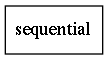

In [9]:
plot_model(generator, show_shapes=True)

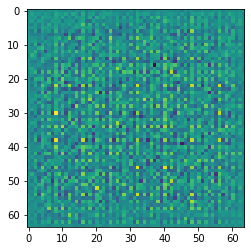

In [10]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [11]:
generated_image.shape

TensorShape([1, 64, 64, 3])

In [12]:
generator.trainable_variables

[<tf.Variable 'conv2d_transpose/kernel:0' shape=(4, 4, 512, 100) dtype=float32, numpy=
 array([[[[-2.12368239e-02,  7.74752162e-03, -5.11316583e-03, ...,
            2.33042333e-02, -4.35397774e-03, -2.28527561e-02],
          [ 1.13057252e-02, -1.09685352e-02,  2.02542562e-02, ...,
           -2.41642930e-02,  2.04092544e-02, -3.55838239e-03],
          [-9.53676738e-03, -1.22133307e-02,  1.48739051e-02, ...,
            1.22458134e-02,  1.08606946e-02,  8.61583836e-03],
          ...,
          [ 1.93947088e-02, -2.41032876e-02,  3.93182039e-03, ...,
           -1.74140073e-02,  1.03659723e-02,  7.96693377e-03],
          [-1.79493800e-03,  5.40330820e-03, -1.07226633e-02, ...,
           -8.61952454e-03, -1.62257515e-02,  2.59706005e-03],
          [ 1.04890484e-02,  1.07022356e-02, -6.42319396e-03, ...,
           -2.01522149e-02,  2.29180176e-02,  4.12144326e-03]],
 
         [[-8.70890915e-04,  5.52829541e-03, -1.56869926e-02, ...,
            1.62780602e-02,  7.97048025e-03, -1.

### 构建判别器

In [ ]:
layers.LeakyReLU?

In [13]:
def make_discriminator_model():
    filters = 64
    model = tf.keras.Sequential([])
    
    
    # 卷积-BN-激活函数:(b, 31, 31, 64)  (64 - 4 + 1) / 2 向上取整
    model.add(layers.Conv2D(filters=filters * 1, kernel_size=4, strides=2, padding='valid', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    # 卷积-BN-激活函数:(b, 14, 14, 128)
    model.add(layers.Conv2D(filters=filters * 2, kernel_size=4, strides=2, padding='valid', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # 卷积-BN-激活函数:(b, 6, 6, 256)
    model.add(layers.Conv2D(filters=filters * 4, kernel_size=4, strides=2, padding='valid', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    # 卷积-BN-激活函数:(b, 4, 4, 512)
    model.add(layers.Conv2D(filters=filters * 8, kernel_size=3, strides=1, padding='valid', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    

    # 卷积-BN-激活函数:(b, 2, 2, 1024)
    model.add(layers.Conv2D(filters=filters * 16, kernel_size=3, strides=1, padding='valid', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # (b, 1024)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Flatten())
    model.add(layers.Dense(1))  # logits 输出

    return model

In [14]:
discriminator = make_discriminator_model()
discriminator.build(input_shape=(4, 64, 64, 3))

In [15]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  3072      
_________________________________________________________________
batch_normalization_4 (Batch multiple                  256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      multiple                  0         
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  131072    
_________________________________________________________________
batch_normalization_5 (Batch multiple                  512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    multiple                 

## 3. 定义损失函数

In [16]:
# 判别器和生成器的损失
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    # real 越接近1越好
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # fake 越接近0越好
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return tf.reduce_mean(total_loss)

def generator_loss(fake_output):
    # 生成的数据结果越接近1越好
    loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return tf.reduce_mean(loss)

learning_rate = 2e-4
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

```python3
checkpoint_directory = "/tmp/training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_directory, "ckpt")

checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)
status = checkpoint.restore(tf.train.latest_checkpoint(checkpoint_directory))
for _ in range(num_training_steps):
  optimizer.minimize( ... )  # Variables will be restored on creation.
status.assert_consumed()  # Optional sanity checks.
checkpoint.save(file_prefix=checkpoint_prefix)
```

In [17]:
# # checkpoint
# check_point_dir = './train_checkpoints'
# check_point_prefix = os.path.join(check_point_dir, 'ckpt')
# check_point = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
#                                   discriminator_optimizer = discriminator_optimizer,
#                                   generator=generator,
#                                   discriminator=discriminator)

## 4. 训练函数

In [18]:
STEPS = 300 * 800
z_dim = 100 # 隐向量z维度
K = 1  #  判断器迭代次数 

nums_examples_to_generate = 100
seed = tf.random.normal([nums_examples_to_generate, z_dim])

In [19]:
# restore_check_point = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
#                                   discriminator_optimizer = discriminator_optimizer,
#                                   generator=generator,
#                                   discriminator=discriminator)

生成图片

In [ ]:
def generate_and_save_images(model, val_block_size, image_path, seed):
    def preprocess(img):
        img = ((img + 1.0) * 127.5).astype(np.uint8)
        # img = img.astype(np.uint8)
        return img
    val_out = model(seed, training=False)
    preprocesed = preprocess(val_out.numpy())
    final_image = np.array([])
    single_row = np.array([])
    for b in range(val_out.shape[0]):
        # concat image into a row
        if single_row.size == 0:
            single_row = preprocesed[b, :, :, :]
        else:
            single_row = np.concatenate((single_row, preprocesed[b, :, :, :]), axis=1)

        # concat image row to final_image
        if (b+1) % val_block_size == 0:
            if final_image.size == 0:
                final_image = single_row
            else:
                final_image = np.concatenate((final_image, single_row), axis=0)

            # reset single row
            single_row = np.array([])

    if final_image.shape[2] == 1:
        final_image = np.squeeze(final_image, axis=2)
    # toimage(final_image).save(image_path)
    # io.imsave(image_path, final_image)
    cv2.imwrite(image_path, final_image)

In [30]:
if os.path.exists(r'./generator.ckpt.index'):
    generator.load_weights('generator.ckpt')
    print('Loaded generator chpt!!')
if os.path.exists(r'./discriminator.ckpt.index'):
    discriminator.load_weights('discriminator.ckpt')
    print('Loaded discriminator chpt!!')


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2DTranspose object at 0x7fcd01098450> and <tensorflow.python.keras.layers.core.Reshape object at 0x7fcd010983d0>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fcd01098890> and <tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x7fcd01098250>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2DTranspose object at 0x7fcd0110ad50> and <tensorflow.python.keras.layers.convolutional.Conv2DTranspose object at 0x7fcd01098450>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fcd0110a8d0> and <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fcd01098890>).

Two checkpoint references resolved to diff


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7fcd00f9d110> and <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fcd00fe8150>).
Loaded discriminator chpt!!


In [ ]:
def train():
    d_losses, g_losses = [],[]
    start = time.perf_counter()
    last = 0

    for step in range(STEPS):
        for _ in range(K):
            noise = tf.random.normal([BATCH_SIZE, z_dim])
            images = next(db_iter)
            with tf.GradientTape() as disc_tape:
                generated_images = generator(noise, training=True)
                real_output = discriminator(images, training=True)
                fake_output = discriminator(generated_images, training=True)
                dis_loss = discriminator_loss(real_output, fake_output)

            gradients_of_discriminator = disc_tape.gradient(dis_loss, discriminator.trainable_variables)
            discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

        # 避免更新太多而令 JS 散度上升。
        noise = tf.random.normal([BATCH_SIZE, z_dim])
        with tf.GradientTape() as gen_tape:
            generated_images = generator(noise, training=True)
            fake_output = discriminator(generated_images, training=True)
            gen_loss = generator_loss(fake_output)
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))


        if step%100 == 0:
            now = time.perf_counter() - start
            print(step, 'd-loss:',float(dis_loss), 'g-loss:', float(gen_loss), 'time:', now - last)
            last = now
            d_losses.append(dis_loss)
            g_losses.append(gen_loss)
            # 查看同一个seed 生成的不同图片
            img_path = os.path.join('gan_images1', f'gan-{step}.png')
            noise = tf.random.normal([nums_examples_to_generate, z_dim])
            generate_and_save_images(generator, 10, img_path, noise)
        if step % 5000 == 0:
            generator.save_weights('./check_point/generator.ckpt')
            discriminator.save_weights('./check_point/discriminator.ckpt')
#             check_point.save(file_prefix = check_point_prefix)
    img_path = os.path.join('gan_images1', 'gan-final.png'%step)
    generate_and_save_images(generator, 10, img_path, seed)
    return  d_losses, g_losses  

In [ ]:
d_losses, g_losses = train()



In [ ]:
import zipfile
from pathlib import Path

img_root = Path('./gan_images1')
with zipfile.ZipFile('image1.zip', 'w') as z:
    for img in img_root.iterdir():
        z.write(img)